In [2]:
import sys
import os

import numpy as np
from torch.utils.data import DataLoader
import torch
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
from eofs.standard import Eof
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from py2d.derivative import derivative
from py2d.initialize import initialize_wavenumbers_rfft2, gridgen
from py2d.spectra import spectrum_zonal_average

# Get the current directory of your_script.py
current_dir = os.getcwd()
# Append the dataset directory to the Python path
dataset_path = os.path.join(current_dir, '..', 'dataset')
sys.path.append(dataset_path)
# Now import CustomMatDataset from dataloader.py
from dataloader import CustomMatDataset

In [9]:
dataType = 'Re500_fkx4fky4_r0.1_b20'

# train_data_dir = '../../py2d/examples/results/Re5000_fkx4fky4_r0.1_b20/NoSGS/NX32/dt0.0002_IC1/'
# train_data_dir = '/home/exouser/Documents/karan/data/Re5000_fkx4fky4_r0.1_b20.0/NoSGS/NX256/dt0.0002_IC1/'
train_data_dir = '/home/exouser/Documents/karan/data/' + dataType + '/NoSGS/NX64/dt0.0005_IC1/'

train_batch_size = 50
model_batch_size = 50
normalize = False # Saved samples are de-normalized
get_Omega = True
get_UV = True
downsample_procedure = 'physical'

# model_dir = '../2D_NX256/2D_32_dt0.02_noise_2500/'
# model_dir = '../' + dataType + '/2D_64_spectral_dt0.02_noise_2500/'
model_dir = '../emulator_2D_64_spectral_dt0.0005_noise_2000/'

# model_dir = '../2D_32_spectral_dt0.02_noise_2500/'

# model_dir = '../2D_NX32_old/2D_32_noise_2500/'

# file_range_test =[1000, 2000]

model_data_dir  = model_dir + 'data/'

if train_data_dir == '/home/exouser/Documents/karan/data/Re500_fkx4fky4_r0.1_b20/NoSGS/NX64/dt0.0005_IC1/':
    downsample_factor = 1
    if model_dir == '../Re500_fkx4fky4_r0.1_b20/2D_64_spectral_dt0.02_noise_2500/':
        file_range_test =[5000, 7500]
    if model_dir == '../emulator_2D_64_spectral_dt0.0005_noise_2000/':
        file_range_test =[5000, 7500]

if train_data_dir == '/home/exouser/Documents/karan/data/Re500_fkx4fky4_r0.1_b0/NoSGS/NX64/dt0.0005_IC1/':
    downsample_factor = 1
    if model_dir == '../Re500_fkx4fky4_r0.1_b0/2D_64_spectral_dt0.02_noise_2500/':
        file_range_test =[5000, 7500]

if train_data_dir == '../../py2d/examples/results/Re5000_fkx4fky4_r0.1_b20/NoSGS/NX32/dt0.0002_IC1/':
    downsample_factor = 1
    if model_dir == '../2D_NX32/2D_32_noise_20000/':
        file_range_test =[5000, 25000]
    elif model_dir == '../2D_NX32/2D_32_noise_10000/':
        file_range_test =[5000, 15000]
    elif model_dir == '../2D_NX32/2D_32_noise_5000/':
        file_range_test =[5000, 10000]
    elif model_dir == '../2D_NX32/2D_32_noise_2500/':
        file_range_test =[5000, 7500]
    elif model_dir == '../2D_NX32/2D_32_noise_2000/':
        file_range_test =[5000, 7000]

if train_data_dir == '/home/exouser/Documents/karan/data/Re5000_fkx4fky4_r0.1_b20.0/NoSGS/NX256/dt0.0002_IC2/':
    downsample_factor = 8
    if model_dir == '../2D_NX256/2D_32_dt0.1_noise_20000/':
        file_range_test =[1000, 21000]
    elif model_dir == '../2D_NX256/2D_32_dt0.1_noise_10000/':
        file_range_test =[1000, 11000]
    elif model_dir == '../2D_NX256/2D_32_dt0.1_noise_5000/':
        file_range_test =[1000, 6000]
    elif model_dir == '../2D_NX256/2D_32_dt0.1_noise_2000/':
        file_range_test =[1000, 3000]
    elif model_dir == '../2D_NX256/2D_32_dt0.1_noise_1000/':
        file_range_test =[1000, 2000]
    elif model_dir == '../2D_NX256/2D_32_dt0.1_noise_500/':
        file_range_test =[1000, 1500]

if train_data_dir == '/home/exouser/Documents/karan/data/Re5000_fkx4fky4_r0.1_b20.0/NoSGS/NX256/dt0.0002_IC1/':
    downsample_factor = 8
    if model_dir == '../2D_32_dt0.02_noise_25000/':
        file_range_test =[110000, 125000]
    elif model_dir == '../2D_32_dt0.02_noise_10000/':
        file_range_test =[5000, 15000]
    elif model_dir == '../2D_32_dt0.02_noise_2500/' or model_dir == '../2D_32_spectral_dt0.02_noise_2500/':
        file_range_test =[110000, 112500]
    elif model_dir == '../2D_32_dt0.02_noise_1000/':
        file_range_test =[5000, 6000]
    elif model_dir == '../2D_32_dt0.02_noise_500/':
        file_range_test =[5000, 5500]
    elif model_dir == '../2D_32_dt0.02_noise_100/':
        file_range_test =[5000, 5100]

training_samples = file_range_test[1] - file_range_test[0]
model_batch_num = training_samples // model_batch_size
model_batch_num = 20

# Create Dataset and DataLoader
dataset_train = CustomMatDataset(data_dir=train_data_dir, file_range=file_range_test, downsample_factor=downsample_factor, downsample_procedure=downsample_procedure, get_UV=get_UV, get_Omega=get_Omega,normalize=normalize)
turb_dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Create an iterator for the dataloader
iterator = iter(turb_dataloader_train)
# Fetch one batch from the iterator
train_batch = next(iterator).numpy().astype(np.float32)

model_batch = np.load(model_data_dir + '0.npy')

# Define the domain size and number of grid points
Lx, Ly = 2*np.pi, 2*np.pi # Domain size
Nx, Ny = train_batch.shape[3], train_batch.shape[2] # Number of grid points

# Generate grid with given domain size and number of grid points
Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')

# Initialize wavenumbers for 2D Fourier-based pseudo-spectral differentiation
Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(Nx, Ny, Lx, Ly, INDEXING='ij')




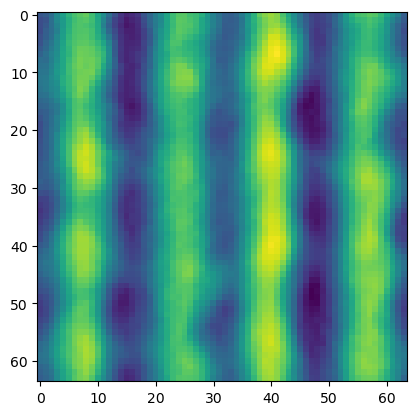

In [3]:
a = train_batch.mean(axis=(0))
plt.imshow(a[2,:,:])

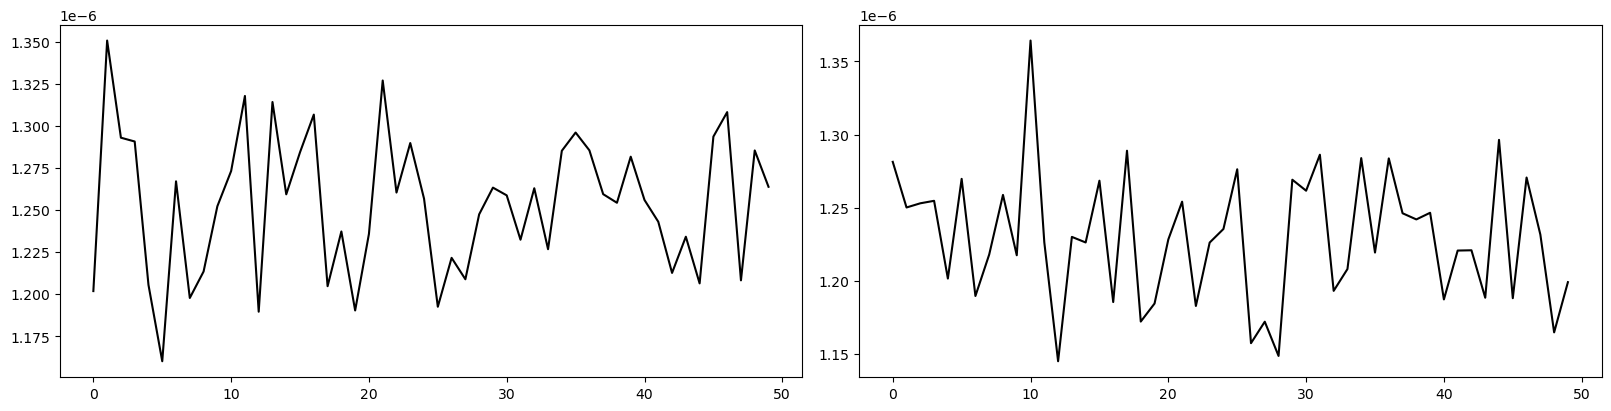

In [5]:
from py2d.util import fft2_to_rfft2

# Create an array of the discrete Fourier Transform sample frequencies in x-direction
kx = 2 * np.pi * np.fft.fftfreq(Nx, d=Lx/Nx)

# Create an array of the discrete Fourier Transform sample frequencies in y-direction
ky = 2 * np.pi * np.fft.fftfreq(Ny, d=Ly/Ny)

# Return coordinate grids (2D arrays) for the x and y wavenumbers
(Kx, Ky) = np.meshgrid(kx, ky, indexing='ij')

# Compute the squared magnitudes of the 2D wavenumbers (Kx and Ky)
Ksq = Kx ** 2 + Ky ** 2

# Compute the absolute value of the wavenumbers
Kabs = np.sqrt(Ksq)

# To avoid division by zero, set the zero wavenumber to a large value 
Ksq[0,0] = 1e16

# Compute the inverse of the squared wavenumbers
invKsq = 1.0 / Ksq
# Set the inverse of the zero wavenumber to zero
invKsq[0,0] = 1e16

# Set the zero wavenumber back to zero
Ksq[0,0] = 0.0

Kx = fft2_to_rfft2(Kx)
Ky = fft2_to_rfft2(Ky)
Kabs = fft2_to_rfft2(Kabs)
Ksq = fft2_to_rfft2(Ksq)
invKsq = fft2_to_rfft2(invKsq)

### Test Continuity Equation on traning data

train_batch = next(iterator).numpy().astype(np.float32)

div_train_arr = []
diff_train_arr = []
for count in range(train_batch.shape[0]):
    data_U = train_batch[count,0,:,:]
    data_V = train_batch[count,1,:,:]
    data_Omega = train_batch[count,2,:,:]

    Ux_train = derivative(data_U,[1,0], Kx, Ky)
    Vy_train = derivative(data_V,[0,1], Kx, Ky)
    Uy_train = derivative(data_U,[0,1], Kx, Ky)
    Vx_train = derivative(data_V,[1,0], Kx, Ky)
    
    Omega_train = Vx_train - Uy_train

    div_train_temp = np.sum(np.abs(Ux_train+Vy_train))/(Nx*Ny)
    diff_omega_temp = np.sum(np.abs(data_Omega-Omega_train))/(Nx*Ny)

    div_train_arr.append(div_train_temp)
    diff_train_arr.append(diff_omega_temp)

fig, axes = plt.subplots(1,2, figsize=(16, 4), layout="compressed")  # Adjust figure size as needed

# div_train_arr = np.mean(div_train_arr,axis=(0))
# div_model_arr = np.mean(div_model_arr,axis=(0))

axes[0].plot(div_train_arr, '-k', label='truth')
axes[1].plot(diff_train_arr, '-k', label='truth')


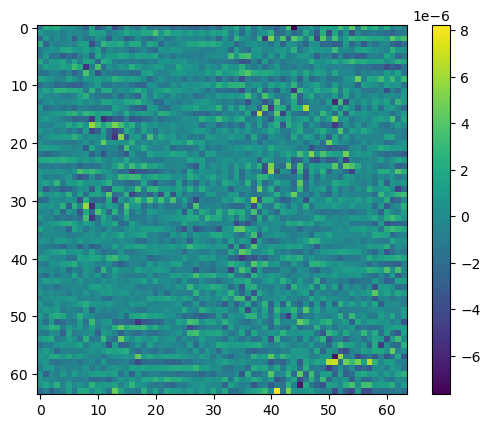

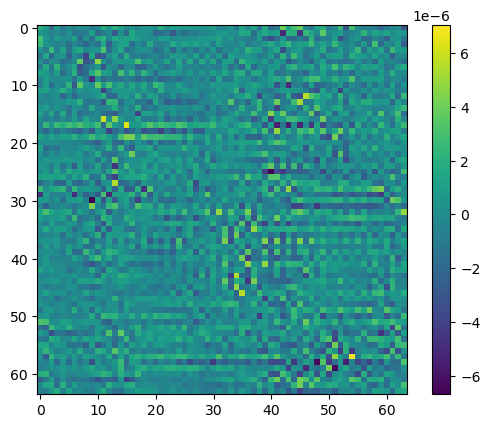

In [6]:
plt.imshow(Ux_train+Vy_train)
plt.colorbar()
plt.show()

plt.imshow(data_Omega-Omega_train)
plt.colorbar()
plt.show()

## Contours of Training and Model Data

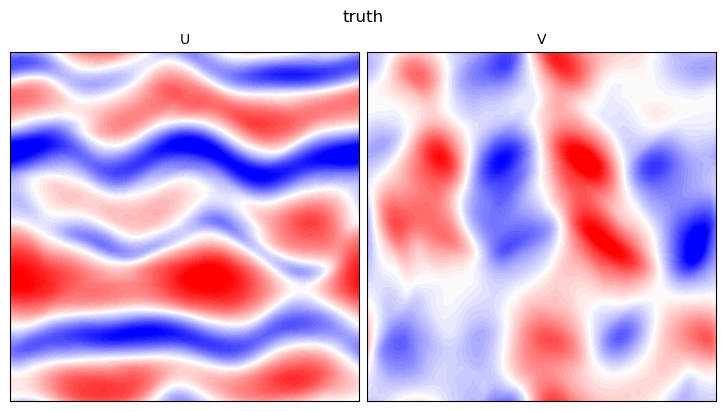

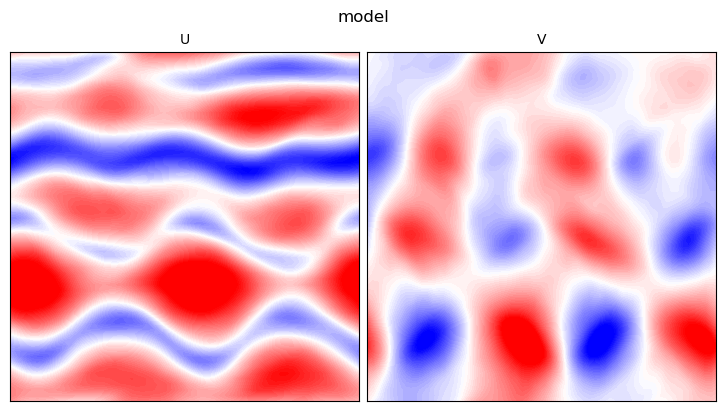

In [17]:
model_batch = np.load(model_data_dir + '0.npy') 

# Set default properties
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

# Set default properties
params = {
    'text.latex.preamble': r'\usepackage{amsmath}',
    'figure.titlesize': BIGGER_SIZE,  # Title size
    'font.size': MEDIUM_SIZE,      # Default font size
    'lines.markersize': 5,       # Default line marker size
    'axes.titlesize': MEDIUM_SIZE,   # Title size
    'axes.labelsize': MEDIUM_SIZE,   
    'legend.fontsize': MEDIUM_SIZE,  # Legend font size 
    'xtick.direction': 'in',     # Ticks inside the panel
    'ytick.direction': 'in',     # Ticks inside the panel
    'xtick.labelsize': SMALL_SIZE,        # x-axis tick label size
    'ytick.labelsize': SMALL_SIZE,        # y-axis tick label size
}
      # Axis label size
plt.rcParams.update(params)

snap_num = 10
cntourLevels = 100

for input in ['truth', 'model']:

    if input == 'truth':
        data = train_batch
    elif input == 'model':
        data = model_batch

    fig, axes = plt.subplots(1,2, figsize=(8, 4), layout="compressed")  # Adjust figure size as needed

    vmax = 0.8*np.max(np.abs(train_batch[snap_num,0,:,:]))
    axes[0].contourf(data[snap_num,0,:,:].T, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
    axes[1].contourf(data[snap_num,1,:,:].T, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

    # axes[0].pcolorfast(data[snap_num,0,:,:].T, cmap='bwr', vmax=vmax, vmin=-vmax)
    # axes[1].pcolorfast(data[snap_num,1,:,:].T, cmap='bwr', vmax=vmax, vmin=-vmax)


    axes[0].set_title('U')
    axes[1].set_title('V')

    for ax in axes.flatten():
        ax.set_aspect('equal', 'box')
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(input)



## Energy Spectra

In [12]:
from scipy.stats import gaussian_kde

def cal_PDF(data_arr):
    # Define bins within 10 standard deviations from the mean, but also limit them within the range of the data
    bin_max = np.min(np.abs([np.min(data_arr), np.max(data_arr)]))
    bin_min = -bin_max
    bins = np.linspace(bin_min, bin_max, 100)

    bw_factor = 1
    bw1 = bw_factor*(data_arr.shape[0])**(-1/5) # custom bw method scott method n**(-1/5)
    kde = gaussian_kde(data_arr, bw_method=bw1)

    # # Define a range over which to evaluate the density
    data_bins = bins
    bw_scott = kde.factor
    # # Evaluate the density over the range
    data_pdf = kde.evaluate(data_bins)

    return data_pdf, data_bins


In [ ]:

n_modes =5 # EOF modes

spectra_train_U_arr = []
spectra_train_V_arr = []
spectra_train_Omega_arr = []
spectra_model_U_arr = []
spectra_model_V_arr = []
spectra_model_Omega_arr = []

zonal_mean_train_U_arr = []
zonal_mean_train_Omega_arr = []
zonal_mean_model_U_arr = []
zonal_mean_model_Omega_arr = []

U_arr = []
V_arr = []
Omega_arr = []

div_train_arr = []

for batch_idx, batch_data in enumerate(turb_dataloader_train):

    train_batch_np = batch_data.numpy().astype(np.float32)
    train_batch_np = batch_data.numpy().astype(np.float32)

    for count in range(train_batch_np.shape[0]):
        data_U = train_batch_np[count,0,:,:].T
        data_V = train_batch_np[count,1,:,:].T
        data_Omega = train_batch_np[count,2,:,:].T

        spectra_U_temp, wavenumber = spectrum_zonal_average(data_U)
        spectra_V_temp, wavenumber = spectrum_zonal_average(data_V)
        spectra_Omega_temp, wavenumber = spectrum_zonal_average(data_Omega)

        Ux_train = derivative(data_U.T,[1,0], Kx, Ky)
        Vy_train = derivative(data_V.T,[0,1], Kx, Ky)
        # div_train_temp = np.linalg.norm(Ux_train+Vy_train)
        # div_train_temp = (Ux_train+Vy_train)
        div_train_temp = np.sum(np.abs(Ux_train+Vy_train))/(Nx*Ny)

        spectra_train_U_arr.append(spectra_U_temp)
        spectra_train_V_arr.append(spectra_V_temp)
        spectra_train_Omega_arr.append(spectra_Omega_temp)

        zonal_mean_train_U_arr.append(np.mean(data_U, axis=1))
        zonal_mean_train_Omega_arr.append(np.mean(data_Omega, axis=1))

        div_train_arr.append(div_train_temp)

        # U_arr = U_arr + data_U
        # V_arr = V_arr + data_V

        U_arr.append(data_U)
        V_arr.append(data_V)
        Omega_arr.append(data_Omega)

U_mean_sample = np.mean(U_arr, axis=0)
V_mean_sample = np.mean(V_arr, axis=0)
Omega_mean_sample = np.mean(Omega_arr, axis=0)
U_std_sample = np.std(U_arr, axis=0)
V_std_sample = np.std(V_arr, axis=0)
Omega_std_sample = np.std(Omega_arr, axis=0)

U_mean = np.mean(U_arr)
V_mean = np.mean(V_arr)
Omega_mean = np.mean(Omega_arr)
U_std = np.std(U_arr)
V_std = np.std(V_arr)
Omega_std = np.std(Omega_arr)

U_max = np.max(U_arr, axis=(1,2))
U_min = np.min(U_arr, axis=(1,2))
V_max = np.max(V_arr, axis=(1,2))
V_min = np.min(V_arr, axis=(1,2))
Omega_max = np.max(Omega_arr, axis=(1,2))
Omega_min = np.min(Omega_arr, axis=(1,2))

PDF_U, bins_U = cal_PDF(np.asarray(U_arr).flatten())
PDF_V, bins_V = cal_PDF(np.asarray(V_arr).flatten())
PDF_Omega, bins_Omega = cal_PDF(np.asarray(Omega_arr).flatten())

del U_arr, V_arr, Omega_arr
# U_mean = U_arr / (training_samples)
# V_mean = V_arr / (training_samples)

spectra_train_U = np.mean(spectra_train_U_arr,axis=0)
spectra_train_V = np.mean(spectra_train_V_arr,axis=0)
spectra_train_Omega = np.mean(spectra_train_Omega_arr,axis=0)
zonal_mean_train_U = np.mean(zonal_mean_train_U_arr,axis=0)
zonal_mean_train_Omega = np.mean(zonal_mean_train_Omega_arr,axis=0)

zonal_mean_train_U_ano = zonal_mean_train_U_arr - np.mean(zonal_mean_train_U_arr,axis=0)
solver = Eof(zonal_mean_train_U_ano)
eofs_train = solver.eofs(neofs=n_modes)
expvar_train = solver.varianceFraction(neigs=n_modes)

# pca = PCA(n_components=n_modes)
# PCs_sklearn = pca.fit_transform(zonal_mean_train_U_ano)
# eofs_train= pca.components_.T
# expvar_train = pca.explained_variance_ratio_

print('batch done')
np.savez(model_dir + 'train_diaagnostics.npz', spectra_train_U=spectra_train_U, spectra_train_V=spectra_train_V, spectra_train_Omega=spectra_train_Omega,
         zonal_mean_train_U=zonal_mean_train_U, zonal_mean_train_Omega=zonal_mean_train_Omega, eofs_train=eofs_train, expvar_train=expvar_train, 
         U_mean_sample=U_mean_sample, V_mean_sample=V_mean_sample, Omega_mean_sample=Omega_mean_sample, U_std_sample=U_std_sample, V_std_sample=V_std_sample, Omega_std_sample=Omega_std_sample, 
         U_mean=U_mean, V_mean=V_mean, Omega_mean=Omega_mean, U_std=U_std, V_std=V_std, Omega_std=Omega_std,
         U_max=U_max, U_min=U_min, V_max=V_max, V_min=V_min, Omega_max=Omega_max, Omega_min=Omega_min,
         PDF_U=PDF_U, bins_U=bins_U, PDF_V=PDF_V, bins_V=bins_V, PDF_Omega=PDF_Omega, bins_Omega=bins_Omega)



In [13]:

n_modes =5 # EOF modes

spectra_train_U_arr = []
spectra_train_V_arr = []
spectra_train_Omega_arr = []
spectra_model_U_arr = []
spectra_model_V_arr = []
spectra_model_Omega_arr = []

zonal_mean_train_U_arr = []
zonal_mean_train_Omega_arr = []
zonal_mean_model_U_arr = []
zonal_mean_model_Omega_arr = []

U_arr = []
V_arr = []
Omega_arr = []

div_train_arr = []

for batch_idx, batch_data in enumerate(turb_dataloader_train):

    train_batch_np = batch_data.numpy().astype(np.float32)
    train_batch_np = batch_data.numpy().astype(np.float32)

    for count in range(train_batch_np.shape[0]):
        data_U = train_batch_np[count,0,:,:].T
        data_V = train_batch_np[count,1,:,:].T
        data_Omega = train_batch_np[count,2,:,:].T

        spectra_U_temp, wavenumber = spectrum_zonal_average(data_U)
        spectra_V_temp, wavenumber = spectrum_zonal_average(data_V)
        spectra_Omega_temp, wavenumber = spectrum_zonal_average(data_Omega)

        Ux_train = derivative(data_U.T,[1,0], Kx, Ky)
        Vy_train = derivative(data_V.T,[0,1], Kx, Ky)
        # div_train_temp = np.linalg.norm(Ux_train+Vy_train)
        # div_train_temp = (Ux_train+Vy_train)
        div_train_temp = np.sum(np.abs(Ux_train+Vy_train))/(Nx*Ny)

        spectra_train_U_arr.append(spectra_U_temp)
        spectra_train_V_arr.append(spectra_V_temp)
        spectra_train_Omega_arr.append(spectra_Omega_temp)

        zonal_mean_train_U_arr.append(np.mean(data_U, axis=1))
        zonal_mean_train_Omega_arr.append(np.mean(data_Omega, axis=1))

        div_train_arr.append(div_train_temp)

        # U_arr = U_arr + data_U
        # V_arr = V_arr + data_V

        U_arr.append(data_U)
        V_arr.append(data_V)
        Omega_arr.append(data_Omega)

U_mean_sample = np.mean(U_arr, axis=0)
V_mean_sample = np.mean(V_arr, axis=0)
Omega_mean_sample = np.mean(Omega_arr, axis=0)
U_std_sample = np.std(U_arr, axis=0)
V_std_sample = np.std(V_arr, axis=0)
Omega_std_sample = np.std(Omega_arr, axis=0)

U_mean = np.mean(U_arr)
V_mean = np.mean(V_arr)
Omega_mean = np.mean(Omega_arr)
U_std = np.std(U_arr)
V_std = np.std(V_arr)
Omega_std = np.std(Omega_arr)

U_max = np.max(U_arr, axis=(1,2))
U_min = np.min(U_arr, axis=(1,2))
V_max = np.max(V_arr, axis=(1,2))
V_min = np.min(V_arr, axis=(1,2))
Omega_max = np.max(Omega_arr, axis=(1,2))
Omega_min = np.min(Omega_arr, axis=(1,2))

PDF_U, bins_U = cal_PDF(np.asarray(U_arr).flatten())
PDF_V, bins_V = cal_PDF(np.asarray(V_arr).flatten())
PDF_Omega, bins_Omega = cal_PDF(np.asarray(Omega_arr).flatten())

del U_arr, V_arr, Omega_arr
# U_mean = U_arr / (training_samples)
# V_mean = V_arr / (training_samples)

spectra_train_U = np.mean(spectra_train_U_arr,axis=0)
spectra_train_V = np.mean(spectra_train_V_arr,axis=0)
spectra_train_Omega = np.mean(spectra_train_Omega_arr,axis=0)
zonal_mean_train_U = np.mean(zonal_mean_train_U_arr,axis=0)
zonal_mean_train_Omega = np.mean(zonal_mean_train_Omega_arr,axis=0)

zonal_mean_train_U_ano = zonal_mean_train_U_arr - np.mean(zonal_mean_train_U_arr,axis=0)
solver = Eof(zonal_mean_train_U_ano)
eofs_train = solver.eofs(neofs=n_modes)
expvar_train = solver.varianceFraction(neigs=n_modes)

# pca = PCA(n_components=n_modes)
# PCs_sklearn = pca.fit_transform(zonal_mean_train_U_ano)
# eofs_train= pca.components_.T
# expvar_train = pca.explained_variance_ratio_

print('batch done')
np.savez(model_dir + 'train_diaagnostics.npz', spectra_train_U=spectra_train_U, spectra_train_V=spectra_train_V, spectra_train_Omega=spectra_train_Omega,
         zonal_mean_train_U=zonal_mean_train_U, zonal_mean_train_Omega=zonal_mean_train_Omega, eofs_train=eofs_train, expvar_train=expvar_train, 
         U_mean_sample=U_mean_sample, V_mean_sample=V_mean_sample, Omega_mean_sample=Omega_mean_sample, U_std_sample=U_std_sample, V_std_sample=V_std_sample, Omega_std_sample=Omega_std_sample, 
         U_mean=U_mean, V_mean=V_mean, Omega_mean=Omega_mean, U_std=U_std, V_std=V_std, Omega_std=Omega_std,
         U_max=U_max, U_min=U_min, V_max=V_max, V_min=V_min, Omega_max=Omega_max, Omega_min=Omega_min,
         PDF_U=PDF_U, bins_U=bins_U, PDF_V=PDF_V, bins_V=bins_V, PDF_Omega=PDF_Omega, bins_Omega=bins_Omega)

spectra_train_U_arr = []
spectra_train_V_arr = []
spectra_train_Omega_arr = []
spectra_model_U_arr = []
spectra_model_V_arr = []
spectra_model_Omega_arr = []

zonal_mean_train_U_arr = []
zonal_mean_train_Omega_arr = []
zonal_mean_model_U_arr = []
zonal_mean_model_Omega_arr = []

# U_min = []
# U_max = []
# V_min = []
# V_max = []

div_model_arr = []

U_arr = []
V_arr = []
Omega_arr = []

for count_model in range(model_batch_num):
    print(count_model)

    try:
        model_batch = np.load(model_data_dir + f'{count_model}.npy')
    except Exception as e:
        print(f'count_model error: {e}')

    for count in range(model_batch.shape[0]):
        data_U = model_batch[count,0,:,:].T
        data_V = model_batch[count,1,:,:].T

        spectra_U_temp, wavenumber = spectrum_zonal_average(data_U)
        spectra_V_temp, wavenumber = spectrum_zonal_average(data_V)

        Ux_model = derivative(data_U.T,[1,0], Kx, Ky)
        Uy_model = derivative(data_U.T,[0,1], Kx, Ky)
        Vy_model = derivative(data_V.T,[0,1], Kx, Ky)
        Vx_model = derivative(data_V.T,[1,0], Kx, Ky)
        # div_model_temp = np.linalg.norm(Ux_model+Vy_model)
        # div_model_temp = (Ux_model+Vy_model)

        data_Omega = Vx_model - Uy_model
        data_Omega = data_Omega.T
        spectra_Omega_temp, wavenumber = spectrum_zonal_average(data_Omega)

        div_model_temp = np.sum(np.abs(Ux_model+Vy_model))/(Nx*Ny)

        spectra_model_U_arr.append(spectra_U_temp)
        spectra_model_V_arr.append(spectra_V_temp)
        spectra_model_Omega_arr.append(spectra_Omega_temp)

        zonal_mean_model_U_arr.append(np.mean(data_U, axis=1))
        zonal_mean_model_Omega_arr.append(np.mean(data_Omega, axis=1))

        div_model_arr.append(div_model_temp)

        U_arr.append(data_U)
        V_arr.append(data_V)
        Omega_arr.append(data_Omega)


U_mean_sample = np.mean(U_arr, axis=0)
V_mean_sample = np.mean(V_arr, axis=0)
Omega_mean_sample = np.mean(Omega_arr, axis=0)
U_std_sample = np.std(U_arr, axis=0)
V_std_sample = np.std(V_arr, axis=0)
Omega_std_sample = np.std(Omega_arr, axis=0)

U_mean = np.mean(U_arr)
V_mean = np.mean(V_arr)
Omega_mean = np.mean(Omega_arr)
U_std = np.std(U_arr)
V_std = np.std(V_arr)
Omega_std = np.std(Omega_arr)

U_max = np.max(U_arr, axis=(1,2))
U_min = np.min(U_arr, axis=(1,2))
V_max = np.max(V_arr, axis=(1,2))
V_min = np.min(V_arr, axis=(1,2))
Omega_max = np.max(Omega_arr, axis=(1,2))
Omega_min = np.min(Omega_arr, axis=(1,2))

PDF_U, bins_U = cal_PDF(np.asarray(U_arr).flatten())
PDF_V, bins_V = cal_PDF(np.asarray(V_arr).flatten())
PDF_Omega, bins_Omega = cal_PDF(np.asarray(Omega_arr).flatten())

del U_arr, V_arr, Omega_arr
        

#         U_max.append(np.max(data_U))
#         U_min.append(np.min(data_U))
#         V_max.append(np.max(data_V))
#         V_min.append(np.min(data_V))

#         if  count == 0:
#             U_arr.append(data_U.flatten())
#             V_arr.append(data_U.flatten())

# U_std = np.std(U_arr)
# V_std = np.std(V_arr)

spectra_model_U = np.mean(spectra_model_U_arr,axis=0)
spectra_model_V = np.mean(spectra_model_V_arr,axis=0)
spectra_model_Omega = np.mean(spectra_model_Omega_arr,axis=0)
zonal_mean_model_U = np.mean(zonal_mean_model_U_arr,axis=0)
zonal_mean_model_Omega = np.mean(zonal_mean_model_Omega_arr,axis=0)

zonal_mean_model_U_ano = zonal_mean_model_U_arr - np.mean(zonal_mean_model_U_arr,axis=0)
solver = Eof(zonal_mean_model_U_ano)
eofs_model = solver.eofs(neofs=n_modes)
expvar_model = solver.varianceFraction(neigs=n_modes)

# pca = PCA(n_components=n_modes)
# PCs_sklearn = pca.fit_transform(zonal_mean_model_U_ano)
# eofs_model= pca.components_.T
# expvar_model = pca.explained_variance_ratio_

np.savez(model_dir + 'model_diaagnostics.npz', spectra_model_U=spectra_model_U, spectra_model_V=spectra_model_V, spectra_model_Omega=spectra_model_Omega,
         zonal_mean_model_U=zonal_mean_model_U, zonal_mean_model_Omega=zonal_mean_model_Omega,
         eofs_model=eofs_model, expvar_model=expvar_model, 
         U_mean_sample=U_mean_sample, V_mean_sample=V_mean_sample, Omega_mean_sample=Omega_mean_sample, U_std_sample=U_std_sample, V_std_sample=V_std_sample, Omega_std_sample=Omega_std_sample,
         U_mean=U_mean, V_mean=V_mean, Omega_mean=Omega_mean, U_std=U_std, V_std=V_std, Omega_std=Omega_std,
         U_max=U_max, U_min=U_min, V_max=V_max, V_min=V_min, Omega_max=Omega_max, Omega_min=Omega_min,
         PDF_U=PDF_U, bins_U=bins_U, PDF_V=PDF_V, bins_V=bins_V, PDF_Omega=PDF_Omega, bins_Omega=bins_Omega)
# np.savez(model_dir + 'model_UV_max_min.npz', U_max=U_max, U_min=U_min, V_max=V_max, V_min=V_min, U_std=U_std, V_std=V_std)


batch done
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [13]:
### PDF of the whole truth

file_range_test =[5000, 100000]

U_arr = []
V_arr = []
Omega_arr = []

# Create Dataset and DataLoader
dataset_train = CustomMatDataset(data_dir=train_data_dir, file_range=file_range_test, downsample_factor=downsample_factor, downsample_procedure=downsample_procedure, get_UV=get_UV, get_Omega=get_Omega,normalize=normalize)
turb_dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)

for batch_idx, batch_data in enumerate(turb_dataloader_train):

    train_batch_np = batch_data.numpy().astype(np.float32)
    train_batch_np = batch_data.numpy().astype(np.float32)

    for count in range(train_batch_np.shape[0]):
        data_U = train_batch_np[count,0,:,:].T
        data_V = train_batch_np[count,1,:,:].T
        data_Omega = train_batch_np[count,2,:,:].T

        U_arr.append(data_U)
        V_arr.append(data_V)
        Omega_arr.append(data_Omega)

    if batch_idx%100 == 0:
        print(batch_idx)

U_mean = np.mean(U_arr)
V_mean = np.mean(V_arr)
Omega_mean = np.mean(Omega_arr)
U_std = np.std(U_arr)
V_std = np.std(V_arr)
Omega_std = np.std(Omega_arr)

U_max = np.max(U_arr, axis=(1,2))
U_min = np.min(U_arr, axis=(1,2))
V_max = np.max(V_arr, axis=(1,2))
V_min = np.min(V_arr, axis=(1,2))
Omega_max = np.max(Omega_arr, axis=(1,2))
Omega_min = np.min(Omega_arr, axis=(1,2))

PDF_U, bins_U = cal_PDF(np.asarray(U_arr).flatten())
PDF_V, bins_V = cal_PDF(np.asarray(V_arr).flatten())
PDF_Omega, bins_Omega = cal_PDF(np.asarray(Omega_arr).flatten())

del U_arr, V_arr, Omega_arr

print('batch done')
np.savez(model_dir + 'truth_diaagnostics.npz', 
         U_mean=U_mean, V_mean=V_mean, Omega_mean=Omega_mean, U_std=U_std, V_std=V_std, Omega_std=Omega_std,
         U_max=U_max, U_min=U_min, V_max=V_max, V_min=V_min, Omega_max=Omega_max, Omega_min=Omega_min,
         PDF_U=PDF_U, bins_U=bins_U, PDF_V=PDF_V, bins_V=bins_V, PDF_Omega=PDF_Omega, bins_Omega=bins_Omega)


0
100
200
300
400


500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
batch done


/tmp/ipykernel_44688/3502804474.py:169: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([1e-8, 0])


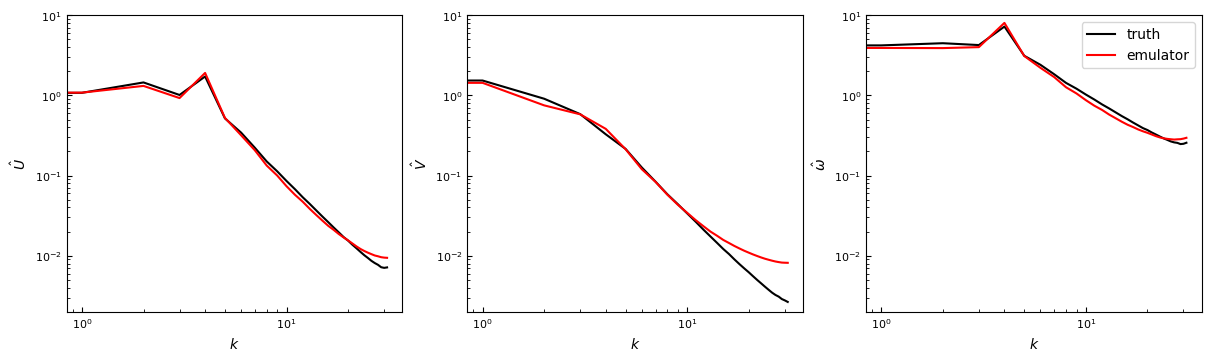

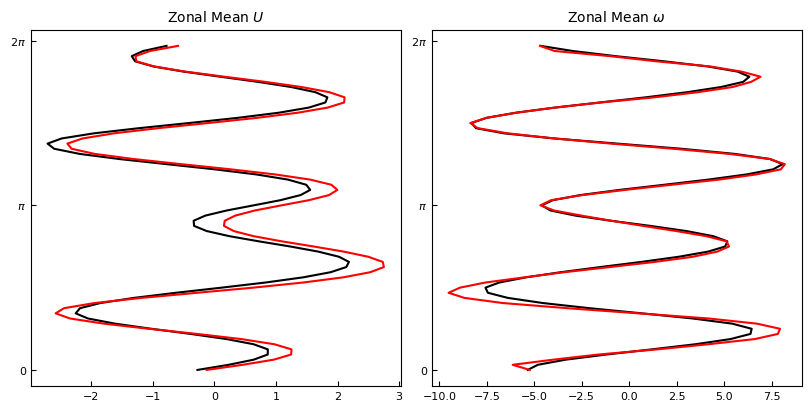

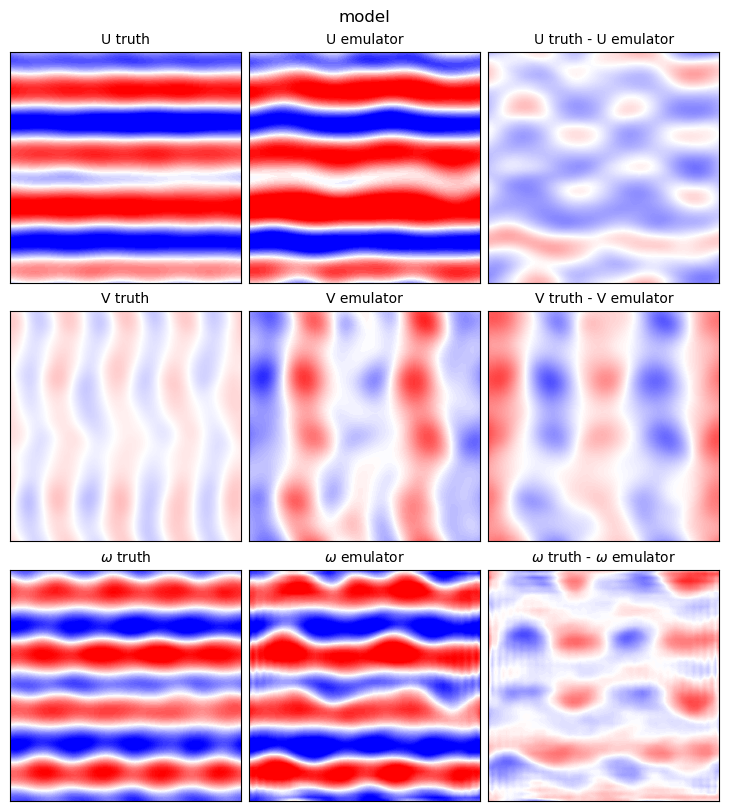

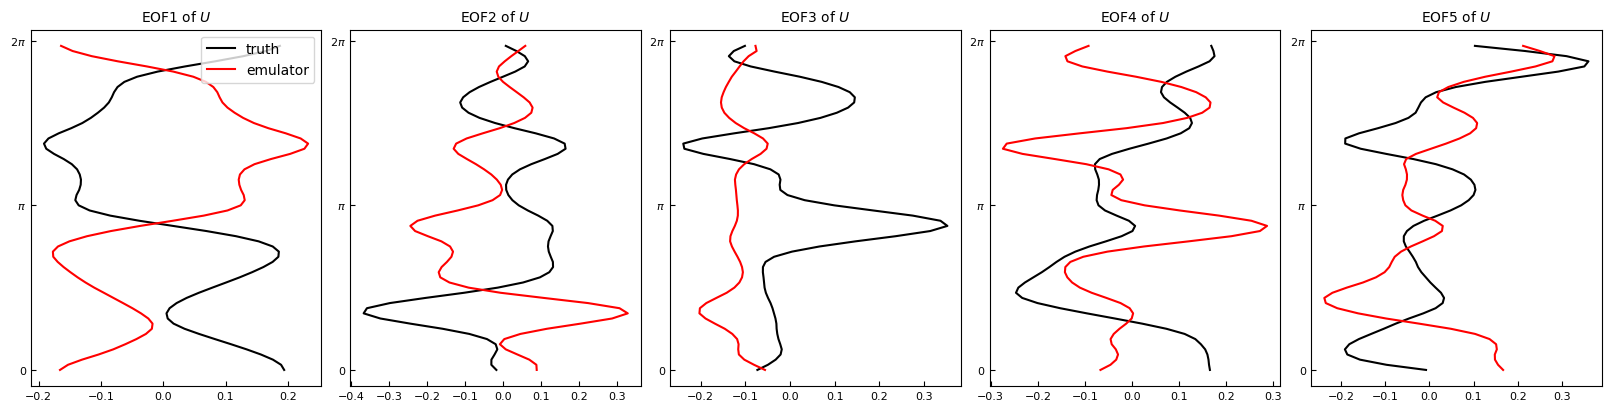

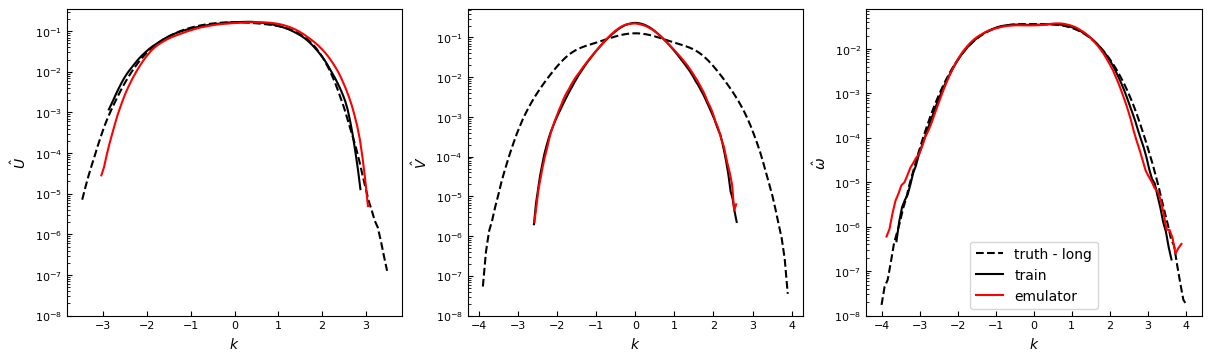

In [15]:
data_truth = np.load(model_dir + 'truth_diaagnostics.npz')
data_train = np.load(model_dir + 'train_diaagnostics.npz')
data_model = np.load(model_dir + 'model_diaagnostics.npz')

spectra_train_U = data_train['spectra_train_U']
spectra_train_V = data_train['spectra_train_V']
spectra_train_Omega = data_train['spectra_train_Omega']
zonal_mean_train_U = data_train['zonal_mean_train_U']
zonal_mean_train_Omega = data_train['zonal_mean_train_Omega']
eofs_train = data_train['eofs_train']
expvar_train = data_train['expvar_train']
U_mean_sample_train = data_train['U_mean_sample']
V_mean_sample_train = data_train['V_mean_sample']
Omega_mean_sample_train = data_train['Omega_mean_sample']
PDF_U_train = data_train['PDF_U']
bins_U_train = data_train['bins_U']
PDF_V_train = data_train['PDF_V']
bins_V_train = data_train['bins_V']
PDF_Omega_train = data_train['PDF_Omega']
bins_Omega_train = data_train['bins_Omega']

spectra_model_U = data_model['spectra_model_U']
spectra_model_V = data_model['spectra_model_V']
spectra_model_Omega = data_model['spectra_model_Omega']
zonal_mean_model_U = data_model['zonal_mean_model_U']
zonal_mean_model_Omega = data_model['zonal_mean_model_Omega']
eofs_model = data_model['eofs_model']
expvar_model = data_model['expvar_model']
U_mean_sample_model = data_model['U_mean_sample']
V_mean_sample_model = data_model['V_mean_sample']
Omega_mean_sample_model = data_model['Omega_mean_sample']
PDF_U_model = data_model['PDF_U']
bins_U_model = data_model['bins_U']
PDF_V_model = data_model['PDF_V']
bins_V_model = data_model['bins_V']
PDF_Omega_model = data_model['PDF_Omega']
bins_Omega_model = data_model['bins_Omega']

U_std = data_truth['U_std']
V_std = data_truth['V_std']
Omega_std = data_truth['Omega_std']
PDF_U_truth = data_truth['PDF_U']
bins_U_truth = data_truth['bins_U']
PDF_V_truth = data_truth['PDF_V']
bins_V_truth = data_truth['bins_V']
PDF_Omega_truth = data_truth['PDF_Omega']
bins_Omega_truth = data_truth['bins_Omega']

fig, axes = plt.subplots(1,3,figsize=(12, 3.5), layout="compressed")  # Adjust figure size as needed
cntourLevels = 100

wavenumber = np.linspace(0,32,33)

axes[0].loglog(wavenumber[:-1], spectra_train_U[:-1], '-k', label='train')
axes[0].loglog(wavenumber[:-1], spectra_model_U[:-1], '-r', label='emulator')
axes[1].loglog(wavenumber[:-1], spectra_train_V[:-1], '-k', label='truth')
axes[1].loglog(wavenumber[:-1], spectra_model_V[:-1], '-r', label='emulator')
axes[2].loglog(wavenumber[:-1], spectra_train_Omega[:-1], '-k', label='truth')
axes[2].loglog(wavenumber[:-1], spectra_model_Omega[:-1], '-r', label='emulator')

for ax in axes.flatten():
    ax.set_xlabel('$k$')
    ax.set_ylim([2e-3, 1e1])

axes[0].set_ylabel('$\hat{U}$')
axes[1].set_ylabel('$\hat{V}$')
axes[2].set_ylabel('$\hat{\omega}$')

plt.legend()

fig, axes = plt.subplots(1,2,figsize=(8, 4), layout="compressed")  # Adjust figure size as needed

dx = Lx/Nx
y = np.linspace(0,2*np.pi-dx,Nx)
axes[0].plot(zonal_mean_train_U, y, '-k', label='truth')
axes[0].plot(zonal_mean_model_U, y, '-r', label='emulator')
axes[0].set_yticks([0, np.pi, 2*np.pi])
axes[0].set_yticklabels(['0', '$\pi$', '$2\pi$'])
axes[0].set_title('Zonal Mean $U$')

y = np.linspace(0,2*np.pi-dx,Nx)
axes[1].plot(zonal_mean_train_Omega, y, '-k', label='truth')
axes[1].plot(zonal_mean_model_Omega, y, '-r', label='emulator')
axes[1].set_yticks([0, np.pi, 2*np.pi])
axes[1].set_yticklabels(['0', '$\pi$', '$2\pi$'])
axes[1].set_title('Zonal Mean $\omega$')

fig, axes = plt.subplots(3,3,figsize=(8, 8), layout="compressed")  # Adjust figure size as needed

vmax = 0.8*np.max(U_mean_sample_train)

# Plotting contours and adding colorbars
contour1 = axes[0, 0].contourf(U_mean_sample_train, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour2 = axes[0, 1].contourf(U_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour3 = axes[0, 2].contourf(U_mean_sample_train - U_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

contour4 = axes[1, 0].contourf(V_mean_sample_train, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour5 = axes[1, 1].contourf(V_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour6 = axes[1, 2].contourf(V_mean_sample_train - V_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

vmax = 0.8*np.max(Omega_mean_sample_train)

contour7 = axes[2, 0].contourf(Omega_mean_sample_train, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour8 = axes[2, 1].contourf(Omega_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour9 = axes[2, 2].contourf(Omega_mean_sample_train - Omega_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

# # Adding colorbars
# fig.colorbar(contour1, ax=axes[0, 0], ticks=np.linspace(-vmax, vmax, num=5))
# fig.colorbar(contour2, ax=axes[0, 1], ticks=np.linspace(-vmax, vmax, num=5))
# fig.colorbar(contour3, ax=axes[0, 2], ticks=np.linspace(-vmax, vmax, num=5))
# fig.colorbar(contour4, ax=axes[1, 0])
# fig.colorbar(contour5, ax=axes[1, 1])
# fig.colorbar(contour6, ax=axes[1, 2])

fig.suptitle('Time averaged mean')
axes[0,0].set_title('U truth')
axes[0,1].set_title('U emulator')
axes[0,2].set_title('U truth - U emulator')

axes[1,0].set_title('V truth')
axes[1,1].set_title('V emulator')
axes[1,2].set_title('V truth - V emulator')

axes[2,0].set_title('$\omega$ truth')
axes[2,1].set_title('$\omega$ emulator')
axes[2,2].set_title('$\omega$ truth - $\omega$ emulator')

for ax in axes.flatten():
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(input)

fig, axes = plt.subplots(1,5,figsize=(16, 4), layout="compressed")  # Adjust figure size as needed

for i in range(5):
    axes[i].plot(eofs_train[i,:], y, '-k', label='truth')
    axes[i].plot(-eofs_model[i,:], y, '-r', label='emulator')
    axes[i].set_yticks([0, np.pi, 2*np.pi])
    axes[i].set_yticklabels(['0', '$\pi$', '$2\pi$'])
    axes[i].set_title(f'EOF{i+1} of $U$')

axes[0].legend()

# PDF
fig, axes = plt.subplots(1,3,figsize=(12, 3.5), layout="compressed")  # Adjust figure size as needed
cntourLevels = 100

axes[0].semilogy(bins_U_truth/U_std, PDF_U_truth, '--k', label='truth - long')
axes[0].semilogy(bins_U_train/U_std, PDF_U_train, '-k', label='train')
axes[0].semilogy(bins_U_model/U_std, PDF_U_model, '-r', label='emulator')
axes[1].semilogy(bins_V_truth/V_std, PDF_V_truth, '--k', label='truth - long')
axes[1].semilogy(bins_V_train/V_std, PDF_V_train, '-k', label='train')
axes[1].semilogy(bins_V_model/V_std, PDF_V_model, '-r', label='emulator')
axes[2].semilogy(bins_Omega_truth/Omega_std, PDF_Omega_truth, '--k', label='truth - long')
axes[2].semilogy(bins_Omega_train/Omega_std, PDF_Omega_train, '-k', label='train')
axes[2].semilogy(bins_Omega_model/Omega_std, PDF_Omega_model, '-r', label='emulator')

# axes[0].semilogy(np.abs(bins_U_train/U_std), PDF_U_train, '-k', label='truth')
# axes[0].semilogy(np.abs(bins_U_model/U_std), PDF_U_model, '-r', label='emulator')
# axes[1].semilogy(np.abs(bins_V_train/V_std), PDF_V_train, '-k', label='truth')
# axes[1].semilogy(np.abs(bins_V_model/V_std), PDF_V_model, '-r', label='emulator')
# axes[2].semilogy(np.abs(bins_Omega_train/Omega_std), PDF_Omega_train, '-k', label='truth')
# axes[2].semilogy(np.abs(bins_Omega_model/Omega_std), PDF_Omega_model, '-r', label='emulator')

for ax in axes.flatten():
    ax.set_xlabel('$k$')
    ax.set_ylim([1e-8, 0])

axes[0].set_ylabel('$\hat{U}$')
axes[1].set_ylabel('$\hat{V}$')
axes[2].set_ylabel('$\hat{\omega}$')

plt.legend()

## Continuity Equation

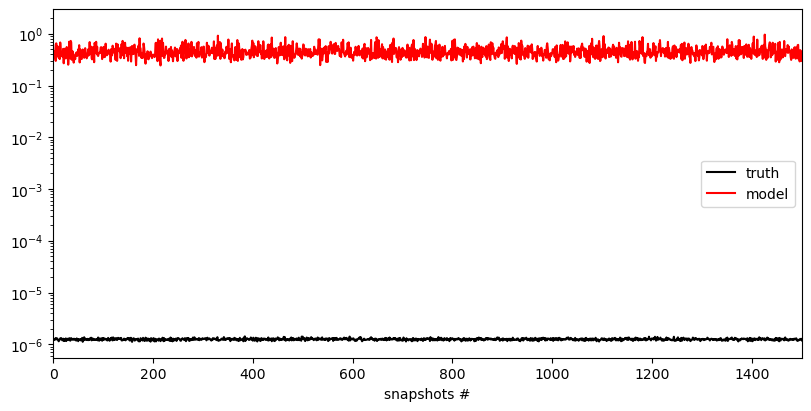

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), layout="compressed")  # Adjust figure size as needed

# div_train_arr = np.mean(div_train_arr,axis=(0))
# div_model_arr = np.mean(div_model_arr,axis=(0))

ax.semilogy(div_train_arr, '-k', label='truth')
ax.semilogy(div_model_arr, '-r', label='model')
ax.set_xlabel('snapshots #')
ax.set_xlabel('snapshots #')

ax.set_xlim([0, 1500])

plt.legend()

### Correlation Coefficient

In [18]:
data_c  = train_batch[:,0,:,:]  # Shape: (100, 1024)
data_c_flat = data_c.reshape(100, -1)  # Shape: (100, 1024)
corr_matrix = np.corrcoef(data_c_flat)  # Shape: (100, 100)
# Extract upper triangle without diagonal
upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
off_diagonal_values = corr_matrix[upper_tri_indices]
average_correlation = np.mean(off_diagonal_values)
average_correlation

np.float64(0.07305764737267978)

In [ ]:
# train_data_dir = '../../py2d/examples/results/Re5000_fkx4fky4_r0.1_b20/NoSGS/NX32/dt0.0002_IC1/data/'
# model_dir = '../2D_32_noise/'
# model_data_dir  = model_dir + 'data/'

# omega_max = []
# omega_min = []

# # Create Dataset and DataLoader
# dataset_all = CustomMatDataset(data_dir=train_data_dir, file_range=[5000, 205000])
# turb_dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# U_max = []
# U_min = []
# V_max = []
# V_min = []

# U_arr = []
# V_arr = []

# for batch_idx, batch_data in enumerate(turb_dataloader_all):
#     data_all = batch_data.numpy()

#     for count in range(data_all.shape[0]):
#         data_U = data_all[count,0,:,:].T
#         data_V = data_all[count,1,:,:].T
#         U_max.append(np.max(data_U))
#         U_min.append(np.min(data_U))
#         V_max.append(np.max(data_V))
#         V_min.append(np.min(data_V))

#         if count == 0:
#             U_arr.append(data_U.flatten())
#             V_arr.append(data_U.flatten())

# U_std = np.std(U_arr)
# V_std = np.std(V_arr)
# U_mean = np.mean(U_arr)
# V_mean = np.mean(V_arr)

# np.savez(model_dir + 'train_UV_max_min.npz', U_max=U_max, U_min=U_min, V_max=V_max, V_min=V_min, U_std=U_std, V_std=V_std, U_mean=U_mean, V_mean=V_mean)

In [ ]:
# # data_dir  = '../../py2d/examples/results/Re5000_fkx4fky4_r0.1_b20/NoSGS/NX32/dt0.0002_IC1/'
# data_dir  = '/home/exouser/Documents/karan/data/Re5000_fkx4fky4_r0.1_b20.0/NoSGS/NX256/dt0.0002_IC1/'

# # train_data_dir = data_dir + 'data/'

# batch_size = 100

# omega_max = []
# omega_min = []

# # Create Dataset and DataLoader
# dataset_all = CustomMatDataset(data_dir=data_dir, file_range=[200000, 210000], downsample_factor=1, get_UV=True, get_Omega=True, get_Psi=True, normalize=False)
# turb_dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# U_arr = []
# V_arr = []
# Psi_arr = []
# Omega_arr = []

# for batch_idx, batch_data in enumerate(turb_dataloader_all):
#     data_all = batch_data.numpy()
#     print(batch_idx)

#     for count in range(data_all.shape[0]):
#         data_Psi= data_all[count,2,:,:].T

#         Psi_arr.append(data_Psi.flatten())
#         # V_arr.append(data_U.flatten())

# Psi_std = np.std(Psi_arr)
# Psi_mean = np.mean(Psi_arr)

# del Psi_arr

# for batch_idx, batch_data in enumerate(turb_dataloader_all):
#     data_all = batch_data.numpy()
#     print(batch_idx)

#     for count in range(data_all.shape[0]):
#         data_Omega= data_all[count,3,:,:].T

#         Omega_arr.append(data_Omega.flatten())

# Omega_std = np.std(Omega_arr)
# Omega_mean = np.mean(Omega_arr)

# del Omega_arr

# for batch_idx, batch_data in enumerate(turb_dataloader_all):
#     data_all = batch_data.numpy()
#     print(batch_idx)

#     for count in range(data_all.shape[0]):
#         data_U = data_all[count,0,:,:].T

#         U_arr.append(data_U.flatten())
#         # V_arr.append(data_U.flatten())

# U_std = np.std(U_arr)
# U_mean = np.mean(U_arr)

# del U_arr

# for batch_idx, batch_data in enumerate(turb_dataloader_all):
#     data_all = batch_data.numpy()
#     print(batch_idx)

#     for count in range(data_all.shape[0]):
#         data_V = data_all[count,1,:,:].T

#     V_arr.append(data_U.flatten())

# V_std = np.std(V_arr)
# V_mean = np.mean(V_arr)

# np.savez(data_dir + 'mean_std.npz', U_std=U_std, V_std=V_std, U_mean=U_mean, V_mean=V_mean, Psi_mean=Psi_mean, Psi_std=Psi_std, Omega_mean=Omega_mean, Omega_std=Omega_std)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


/tmp/ipykernel_44688/3408860181.py:200: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([1e-8, 0])


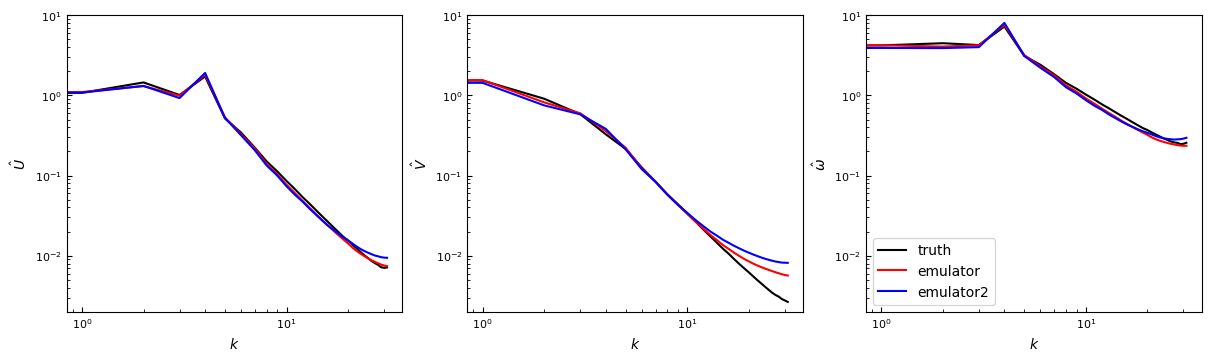

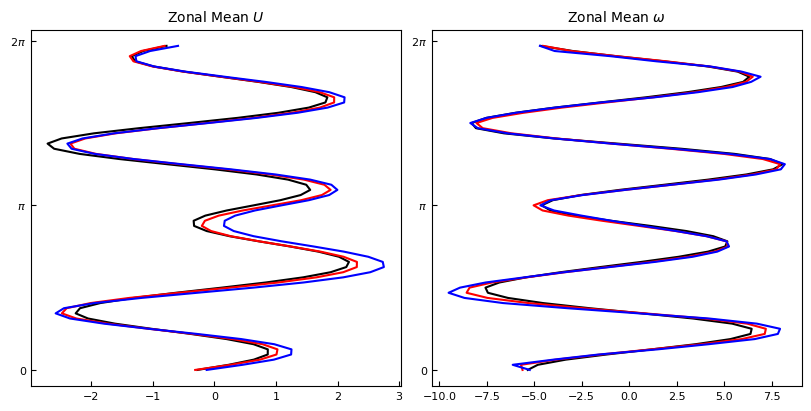

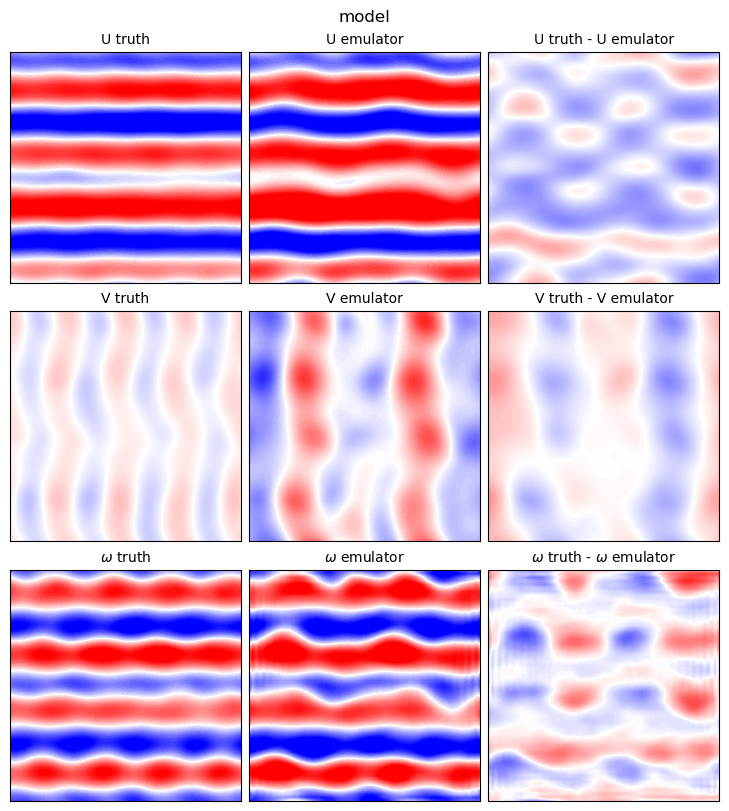

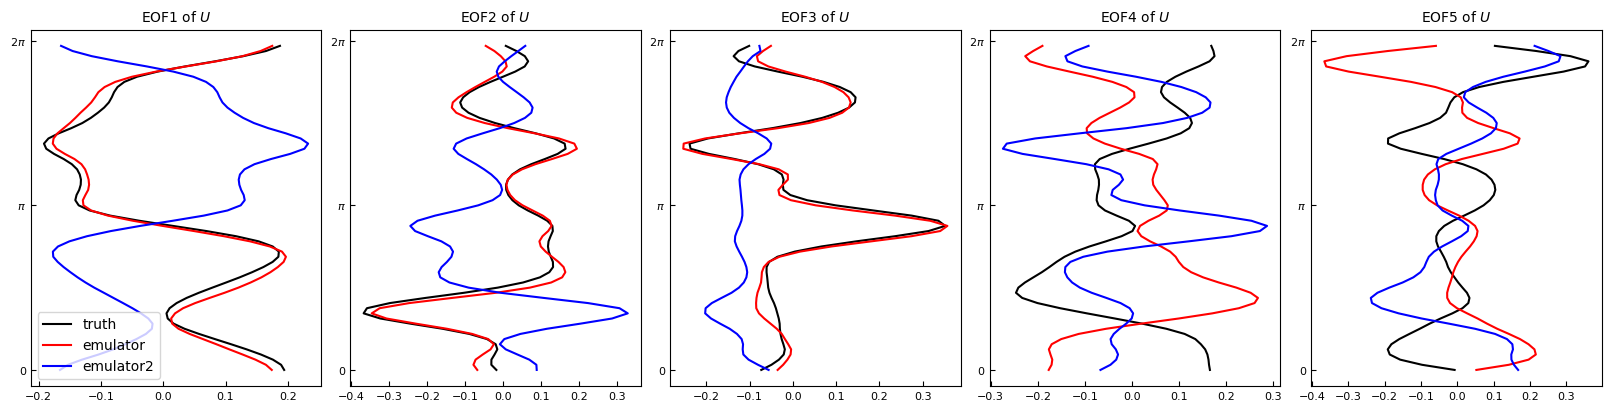

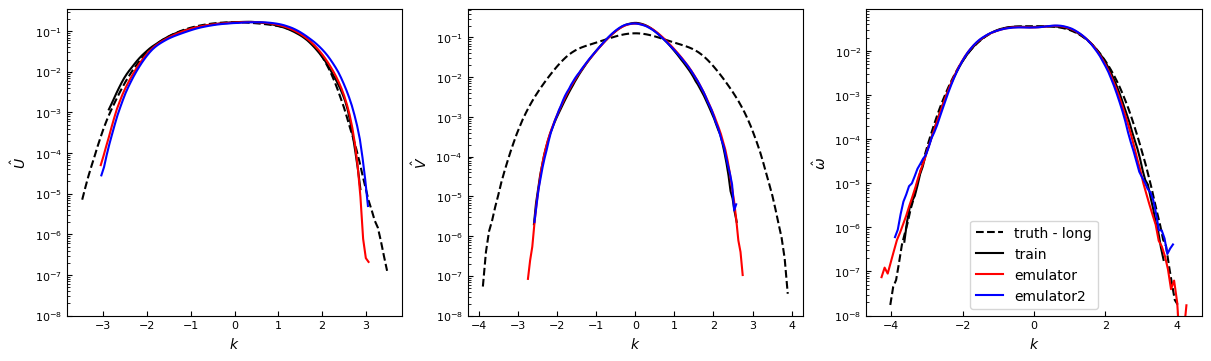

In [16]:

model_dir2 = '../' + dataType + '/2D_64_spectral_dt0.02_noise_2500/'



data_truth = np.load(model_dir + 'truth_diaagnostics.npz')
data_train = np.load(model_dir + 'train_diaagnostics.npz')
data_model = np.load(model_dir2 + 'model_diaagnostics.npz')
data_model2 = np.load(model_dir + 'model_diaagnostics.npz')

spectra_train_U = data_train['spectra_train_U']
spectra_train_V = data_train['spectra_train_V']
spectra_train_Omega = data_train['spectra_train_Omega']
zonal_mean_train_U = data_train['zonal_mean_train_U']
zonal_mean_train_Omega = data_train['zonal_mean_train_Omega']
eofs_train = data_train['eofs_train']
expvar_train = data_train['expvar_train']
U_mean_sample_train = data_train['U_mean_sample']
V_mean_sample_train = data_train['V_mean_sample']
Omega_mean_sample_train = data_train['Omega_mean_sample']
PDF_U_train = data_train['PDF_U']
bins_U_train = data_train['bins_U']
PDF_V_train = data_train['PDF_V']
bins_V_train = data_train['bins_V']
PDF_Omega_train = data_train['PDF_Omega']
bins_Omega_train = data_train['bins_Omega']

spectra_model_U = data_model['spectra_model_U']
spectra_model_V = data_model['spectra_model_V']
spectra_model_Omega = data_model['spectra_model_Omega']
zonal_mean_model_U = data_model['zonal_mean_model_U']
zonal_mean_model_Omega = data_model['zonal_mean_model_Omega']
eofs_model = data_model['eofs_model']
expvar_model = data_model['expvar_model']
U_mean_sample_model = data_model['U_mean_sample']
V_mean_sample_model = data_model['V_mean_sample']
Omega_mean_sample_model = data_model['Omega_mean_sample']
PDF_U_model = data_model['PDF_U']
bins_U_model = data_model['bins_U']
PDF_V_model = data_model['PDF_V']
bins_V_model = data_model['bins_V']
PDF_Omega_model = data_model['PDF_Omega']
bins_Omega_model = data_model['bins_Omega']

spectra_model_U2 = data_model2['spectra_model_U']
spectra_model_V2 = data_model2['spectra_model_V']
spectra_model_Omega2 = data_model2['spectra_model_Omega']
zonal_mean_model_U2 = data_model2['zonal_mean_model_U']
zonal_mean_model_Omega2 = data_model2['zonal_mean_model_Omega']
eofs_model2 = data_model2['eofs_model']
expvar_model2 = data_model2['expvar_model']
U_mean_sample_model2 = data_model2['U_mean_sample']
V_mean_sample_model2 = data_model2['V_mean_sample']
Omega_mean_sample_model2 = data_model2['Omega_mean_sample']
PDF_U_model2 = data_model2['PDF_U']
bins_U_model2 = data_model2['bins_U']
PDF_V_model2 = data_model2['PDF_V']
bins_V_model2 = data_model2['bins_V']
PDF_Omega_model2 = data_model2['PDF_Omega']
bins_Omega_model2 = data_model2['bins_Omega']

U_std = data_truth['U_std']
V_std = data_truth['V_std']
Omega_std = data_truth['Omega_std']
PDF_U_truth = data_truth['PDF_U']
bins_U_truth = data_truth['bins_U']
PDF_V_truth = data_truth['PDF_V']
bins_V_truth = data_truth['bins_V']
PDF_Omega_truth = data_truth['PDF_Omega']
bins_Omega_truth = data_truth['bins_Omega']

fig, axes = plt.subplots(1,3,figsize=(12, 3.5), layout="compressed")  # Adjust figure size as needed
cntourLevels = 100

wavenumber = np.linspace(0,32,33)

axes[0].loglog(wavenumber[:-1], spectra_train_U[:-1], '-k', label='train')
axes[0].loglog(wavenumber[:-1], spectra_model_U[:-1], '-r', label='emulator')
axes[0].loglog(wavenumber[:-1], spectra_model_U2[:-1], '-b', label='emulator2')
axes[1].loglog(wavenumber[:-1], spectra_train_V[:-1], '-k', label='truth')
axes[1].loglog(wavenumber[:-1], spectra_model_V[:-1], '-r', label='emulator')
axes[1].loglog(wavenumber[:-1], spectra_model_V2[:-1], '-b', label='emulator2')
axes[2].loglog(wavenumber[:-1], spectra_train_Omega[:-1], '-k', label='truth')
axes[2].loglog(wavenumber[:-1], spectra_model_Omega[:-1], '-r', label='emulator')
axes[2].loglog(wavenumber[:-1], spectra_model_Omega2[:-1], '-b', label='emulator2')

for ax in axes.flatten():
    ax.set_xlabel('$k$')
    ax.set_ylim([2e-3, 1e1])

axes[0].set_ylabel('$\hat{U}$')
axes[1].set_ylabel('$\hat{V}$')
axes[2].set_ylabel('$\hat{\omega}$')

plt.legend()

fig, axes = plt.subplots(1,2,figsize=(8, 4), layout="compressed")  # Adjust figure size as needed

dx = Lx/Nx
y = np.linspace(0,2*np.pi-dx,Nx)
axes[0].plot(zonal_mean_train_U, y, '-k', label='truth')
axes[0].plot(zonal_mean_model_U, y, '-r', label='emulator')
axes[0].plot(zonal_mean_model_U2, y, '-b', label='emulator2')
axes[0].set_yticks([0, np.pi, 2*np.pi])
axes[0].set_yticklabels(['0', '$\pi$', '$2\pi$'])
axes[0].set_title('Zonal Mean $U$')

y = np.linspace(0,2*np.pi-dx,Nx)
axes[1].plot(zonal_mean_train_Omega, y, '-k', label='truth')
axes[1].plot(zonal_mean_model_Omega, y, '-r', label='emulator')
axes[1].plot(zonal_mean_model_Omega2, y, '-b', label='emulator2')
axes[1].set_yticks([0, np.pi, 2*np.pi])
axes[1].set_yticklabels(['0', '$\pi$', '$2\pi$'])
axes[1].set_title('Zonal Mean $\omega$')

fig, axes = plt.subplots(3,3,figsize=(8, 8), layout="compressed")  # Adjust figure size as needed

vmax = 0.8*np.max(U_mean_sample_train)

# Plotting contours and adding colorbars
contour1 = axes[0, 0].contourf(U_mean_sample_train, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour2 = axes[0, 1].contourf(U_mean_sample_model2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour3 = axes[0, 2].contourf(U_mean_sample_train - U_mean_sample_model2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

contour4 = axes[1, 0].contourf(V_mean_sample_train, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour5 = axes[1, 1].contourf(V_mean_sample_model2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour6 = axes[1, 2].contourf(V_mean_sample_train - V_mean_sample_model, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

vmax = 0.8*np.max(Omega_mean_sample_train)

contour7 = axes[2, 0].contourf(Omega_mean_sample_train, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour8 = axes[2, 1].contourf(Omega_mean_sample_model2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
contour9 = axes[2, 2].contourf(Omega_mean_sample_train - Omega_mean_sample_model2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)

# # Adding colorbars
# fig.colorbar(contour1, ax=axes[0, 0], ticks=np.linspace(-vmax, vmax, num=5))
# fig.colorbar(contour2, ax=axes[0, 1], ticks=np.linspace(-vmax, vmax, num=5))
# fig.colorbar(contour3, ax=axes[0, 2], ticks=np.linspace(-vmax, vmax, num=5))
# fig.colorbar(contour4, ax=axes[1, 0])
# fig.colorbar(contour5, ax=axes[1, 1])
# fig.colorbar(contour6, ax=axes[1, 2])

fig.suptitle('Time averaged mean')
axes[0,0].set_title('U truth')
axes[0,1].set_title('U emulator')
axes[0,2].set_title('U truth - U emulator')

axes[1,0].set_title('V truth')
axes[1,1].set_title('V emulator')
axes[1,2].set_title('V truth - V emulator')

axes[2,0].set_title('$\omega$ truth')
axes[2,1].set_title('$\omega$ emulator')
axes[2,2].set_title('$\omega$ truth - $\omega$ emulator')

for ax in axes.flatten():
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(input)

fig, axes = plt.subplots(1,5,figsize=(16, 4), layout="compressed")  # Adjust figure size as needed

for i in range(5):
    axes[i].plot(eofs_train[i,:], y, '-k', label='truth')
    axes[i].plot(-eofs_model[i,:], y, '-r', label='emulator')
    axes[i].plot(-eofs_model2[i,:], y, '-b', label='emulator2')
    axes[i].set_yticks([0, np.pi, 2*np.pi])
    axes[i].set_yticklabels(['0', '$\pi$', '$2\pi$'])
    axes[i].set_title(f'EOF{i+1} of $U$')

axes[0].legend()

# PDF
fig, axes = plt.subplots(1,3,figsize=(12, 3.5), layout="compressed")  # Adjust figure size as needed
cntourLevels = 100

axes[0].semilogy(bins_U_truth/U_std, PDF_U_truth, '--k', label='truth - long')
axes[0].semilogy(bins_U_train/U_std, PDF_U_train, '-k', label='train')
axes[0].semilogy(bins_U_model/U_std, PDF_U_model, '-r', label='emulator')
axes[0].semilogy(bins_U_model2/U_std, PDF_U_model2, '-b', label='emulator2')
axes[1].semilogy(bins_V_truth/V_std, PDF_V_truth, '--k', label='truth - long')
axes[1].semilogy(bins_V_train/V_std, PDF_V_train, '-k', label='train')
axes[1].semilogy(bins_V_model/V_std, PDF_V_model, '-r', label='emulator')
axes[1].semilogy(bins_V_model2/V_std, PDF_V_model2, '-b', label='emulator2')
axes[2].semilogy(bins_Omega_truth/Omega_std, PDF_Omega_truth, '--k', label='truth - long')
axes[2].semilogy(bins_Omega_train/Omega_std, PDF_Omega_train, '-k', label='train')
axes[2].semilogy(bins_Omega_model/Omega_std, PDF_Omega_model, '-r', label='emulator')
axes[2].semilogy(bins_Omega_model2/Omega_std, PDF_Omega_model2, '-b', label='emulator2')

# axes[0].semilogy(np.abs(bins_U_train/U_std), PDF_U_train, '-k', label='truth')
# axes[0].semilogy(np.abs(bins_U_model/U_std), PDF_U_model, '-r', label='emulator')
# axes[1].semilogy(np.abs(bins_V_train/V_std), PDF_V_train, '-k', label='truth')
# axes[1].semilogy(np.abs(bins_V_model/V_std), PDF_V_model, '-r', label='emulator')
# axes[2].semilogy(np.abs(bins_Omega_train/Omega_std), PDF_Omega_train, '-k', label='truth')
# axes[2].semilogy(np.abs(bins_Omega_model/Omega_std), PDF_Omega_model, '-r', label='emulator')

for ax in axes.flatten():
    ax.set_xlabel('$k$')
    ax.set_ylim([1e-8, 0])

axes[0].set_ylabel('$\hat{U}$')
axes[1].set_ylabel('$\hat{V}$')
axes[2].set_ylabel('$\hat{\omega}$')

plt.legend()